In [1]:
!pip install category_encoders

# 1- Frame the problem and look at the big picture.

### Frame the problem
1. Supervised learning – training examples are labeled.
2. A regression task – predict a numerical value.
3. Batch learning
    - Small data set
    - No continuous flow of data coming into the system
    - No need to adjust to changing data rapidly

### Look at the big picture

Our task is to build a prediction model for estimating the salary of jobs in the data science field using our dataset. We aim to see what aspects of data science influence their salaries and give insight on potential salary estimates. By exploring this data we can not only ourselves and help fellow peers gain a bigger picture of the data science world but we can also find and improve flaws or benefits on the company side to make better decisions on hiring.

In [2]:
# Import libraries
# you can install missing library using pip install numpy

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

###Load Data

In [3]:
# Download the dataset
# If there is no separator, you can use df = pd.read_csv(url)
# If the dataset is on your local machine use df = pd.read_csv("datasets/student/student-mat-modified-RA.csv")
# If reading from UCI directly, some datasets are available thorugh the ucimlrepo (https://github.com/uci-ml-repo/ucimlrepo)

url = "https://raw.githubusercontent.com/HarroldNgo/3401-Final-Project/main/jobs_in_data.csv"
jobs = pd.read_csv(url, sep=',')

# Let's create a backup copy of the dataset
jobs_backup = jobs
jobs

,work_year,job_title,job_category,salary_currency,salary,salary_in_usd,employee_residence,experience_level,employment_type,work_setting,company_location,company_size
0,2023,Data DevOps Engineer,Data Engineering,EUR,88000,95012,Germany,Mid-level,Full-time,Hybrid,Germany,L
1,2023,Data Architect,Data Architecture and Modeling,USD,186000,186000,United States,Senior,Full-time,In-person,United States,M
2,2023,Data Architect,Data Architecture and Modeling,USD,81800,81800,United States,Senior,Full-time,In-person,United States,M
3,2023,Data Scientist,Data Science and Research,USD,212000,212000,United States,Senior,Full-time,In-person,United States,M
4,2023,Data Scientist,Data Science and Research,USD,93300,93300,United States,Senior,Full-time,In-person,United States,M
...,...,...,...,...,...,...,...,...,...,...,...,...
9350,2021,Data Specialist,Data Management and Strategy,USD,165000,165000,United States,Senior,Full-time,Remote,United States,L
9351,2020,Data Scientist,Data Science and Research,USD,412000,412000,United States,Senior,Full-time,Remote,United States,L
9352,2021,Principal Data Scientist,Data Science and Research,USD,151000,151000,United States,Mid-level,Full-time,Remote,United States,L
9353,2020,Data Scientist,Data Science and Research,USD,105000,105000,United States,Entry-level,Full-time,Remote,United States,S


# 2- A description of the dataset and 3+ graphs of EDA

### Description
This dataset contains numerous features related to job salaries in the data science field such as job titles, company size, job category, employee residence, etc. Each entry in the dataset represents and contains information on a unique individual within the data science field. The dataset contains 3 numerical features and 9 categorical features and our target feature we are trying to predict is “salary_in_usd”.


### Graphs of EDA

####Frequency Bar Graphs

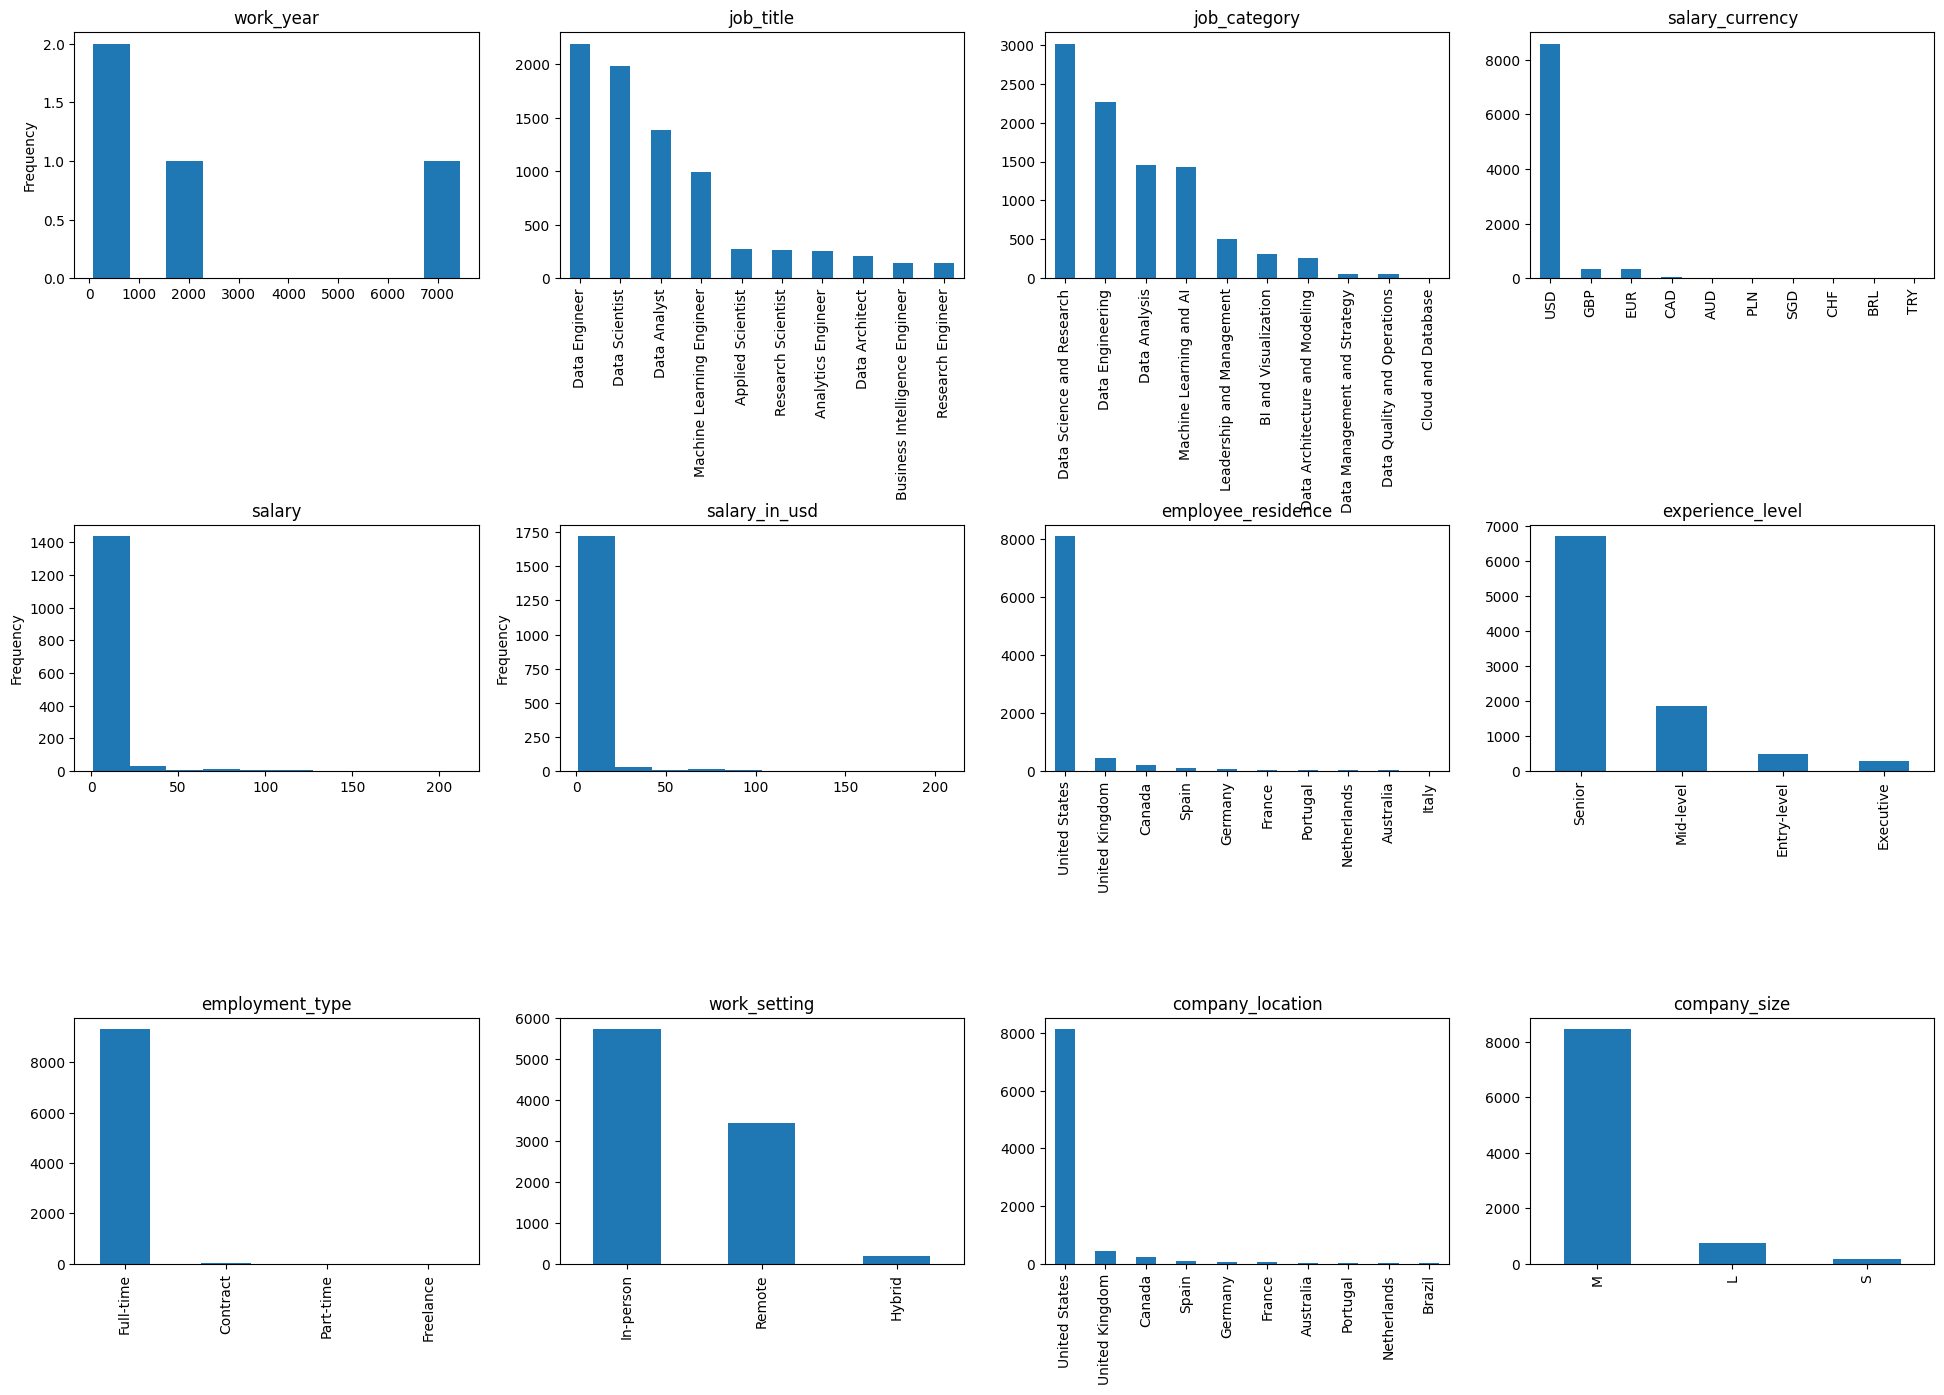

In [4]:
#Setting subplot and for loop to display all columns graphs
rows=3
cols=4
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(24, 16))
plt.subplots_adjust(hspace=1)
i=0
for column in jobs:
  if(pd.api.types.is_numeric_dtype(jobs[column])):
    jobs[column].value_counts().plot(kind='hist', ax=axes[i//cols, i%cols], title=column)
  else:
    jobs[column].value_counts().head(10).plot(kind='bar', ax=axes[i//cols, i%cols], title=column)
  i=i+1


####Boxplots with respect to the target column

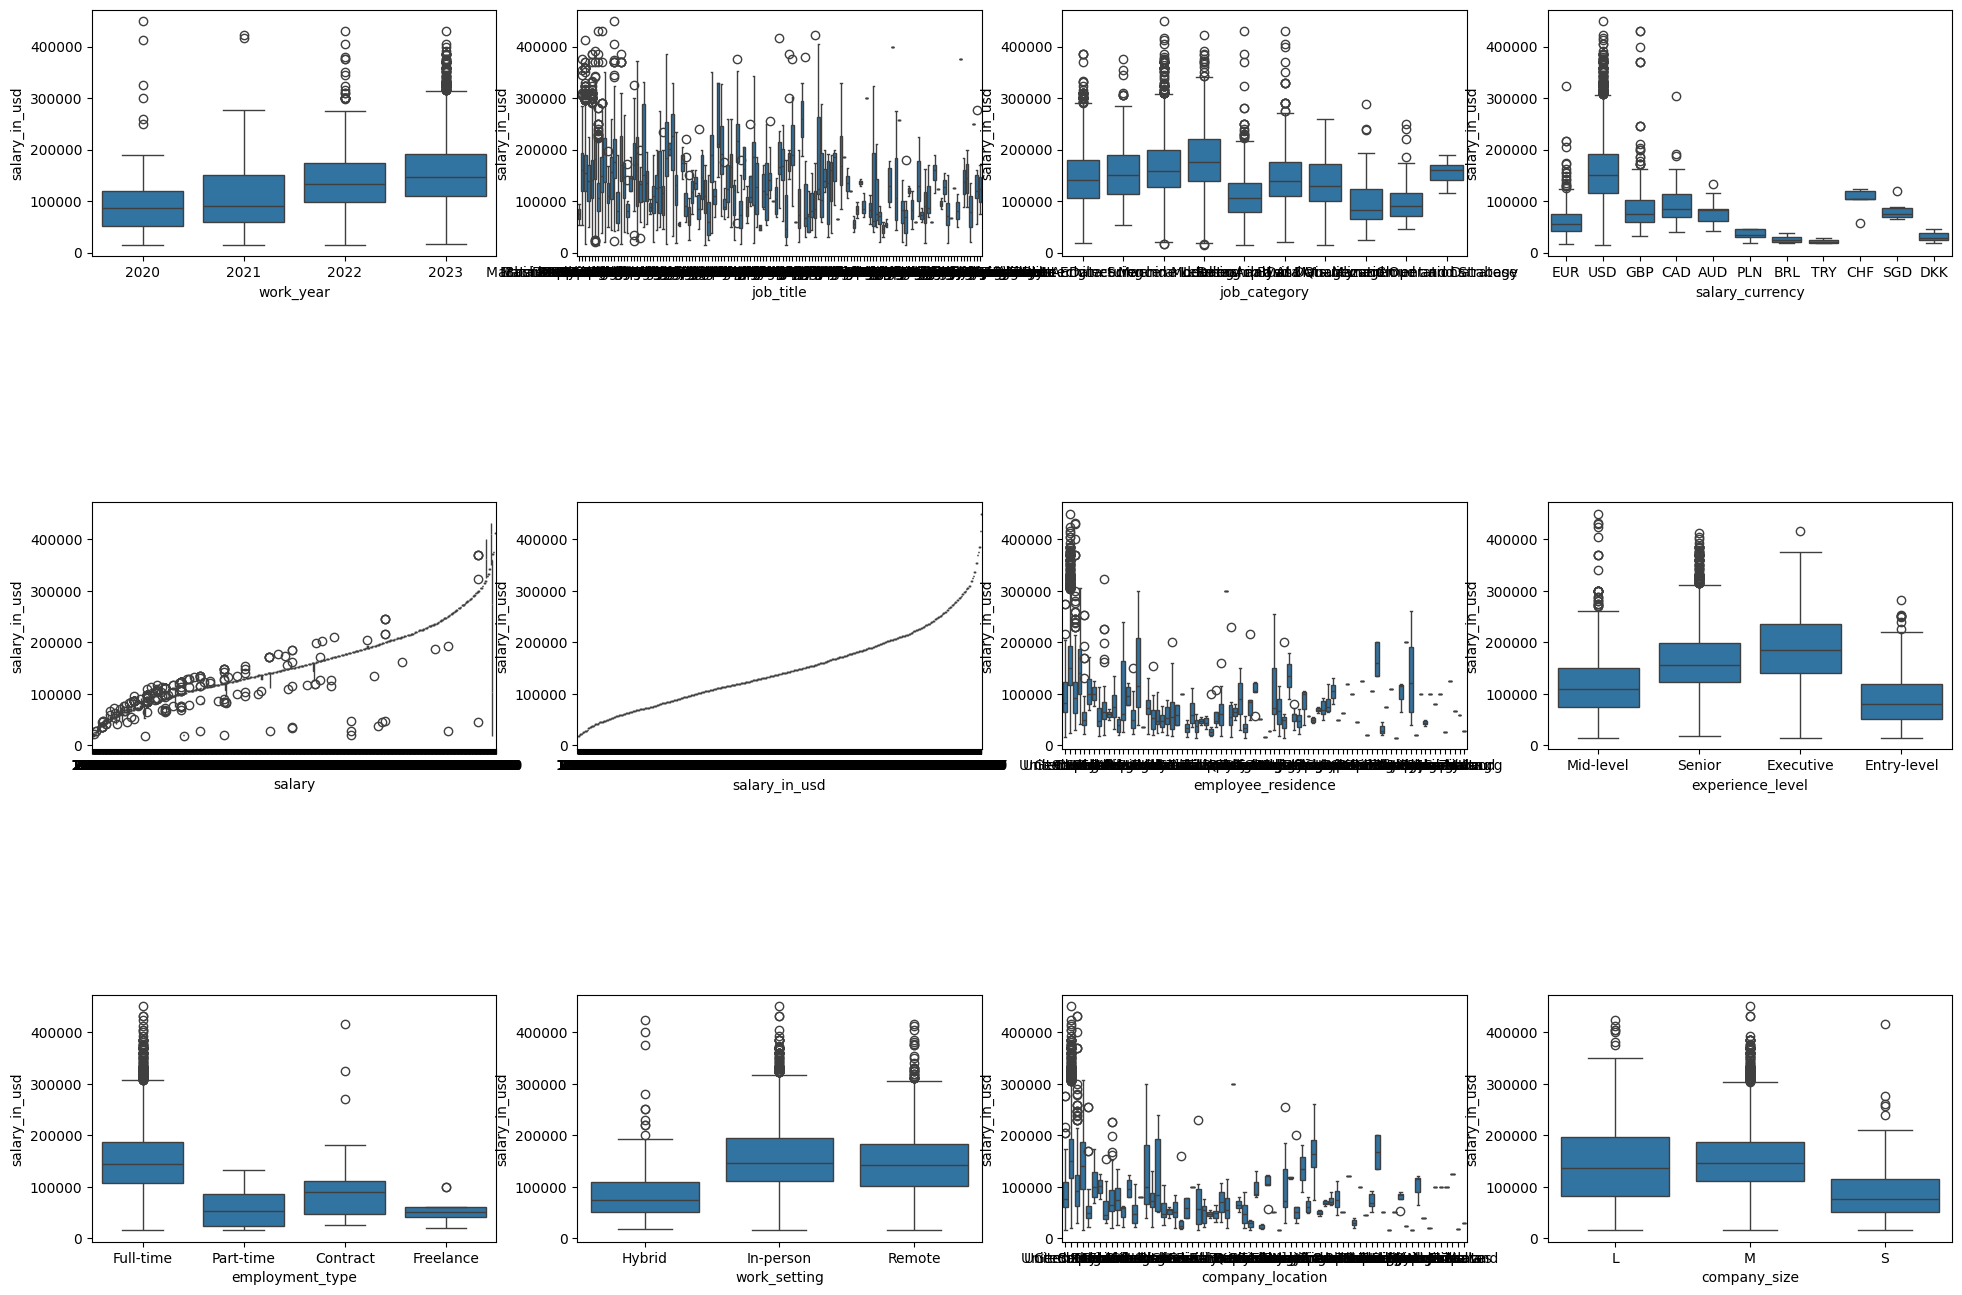

In [5]:
#Setting subplot and for loop to display all columns graphs
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(24, 16))
plt.subplots_adjust(hspace=1)
i=0
for col in jobs.columns:
    sns.boxplot(x=col, y='salary_in_usd', data=jobs, ax=axes[i//cols, i%cols])
    i=i+1

####Lineplot with the most central column from the box plots

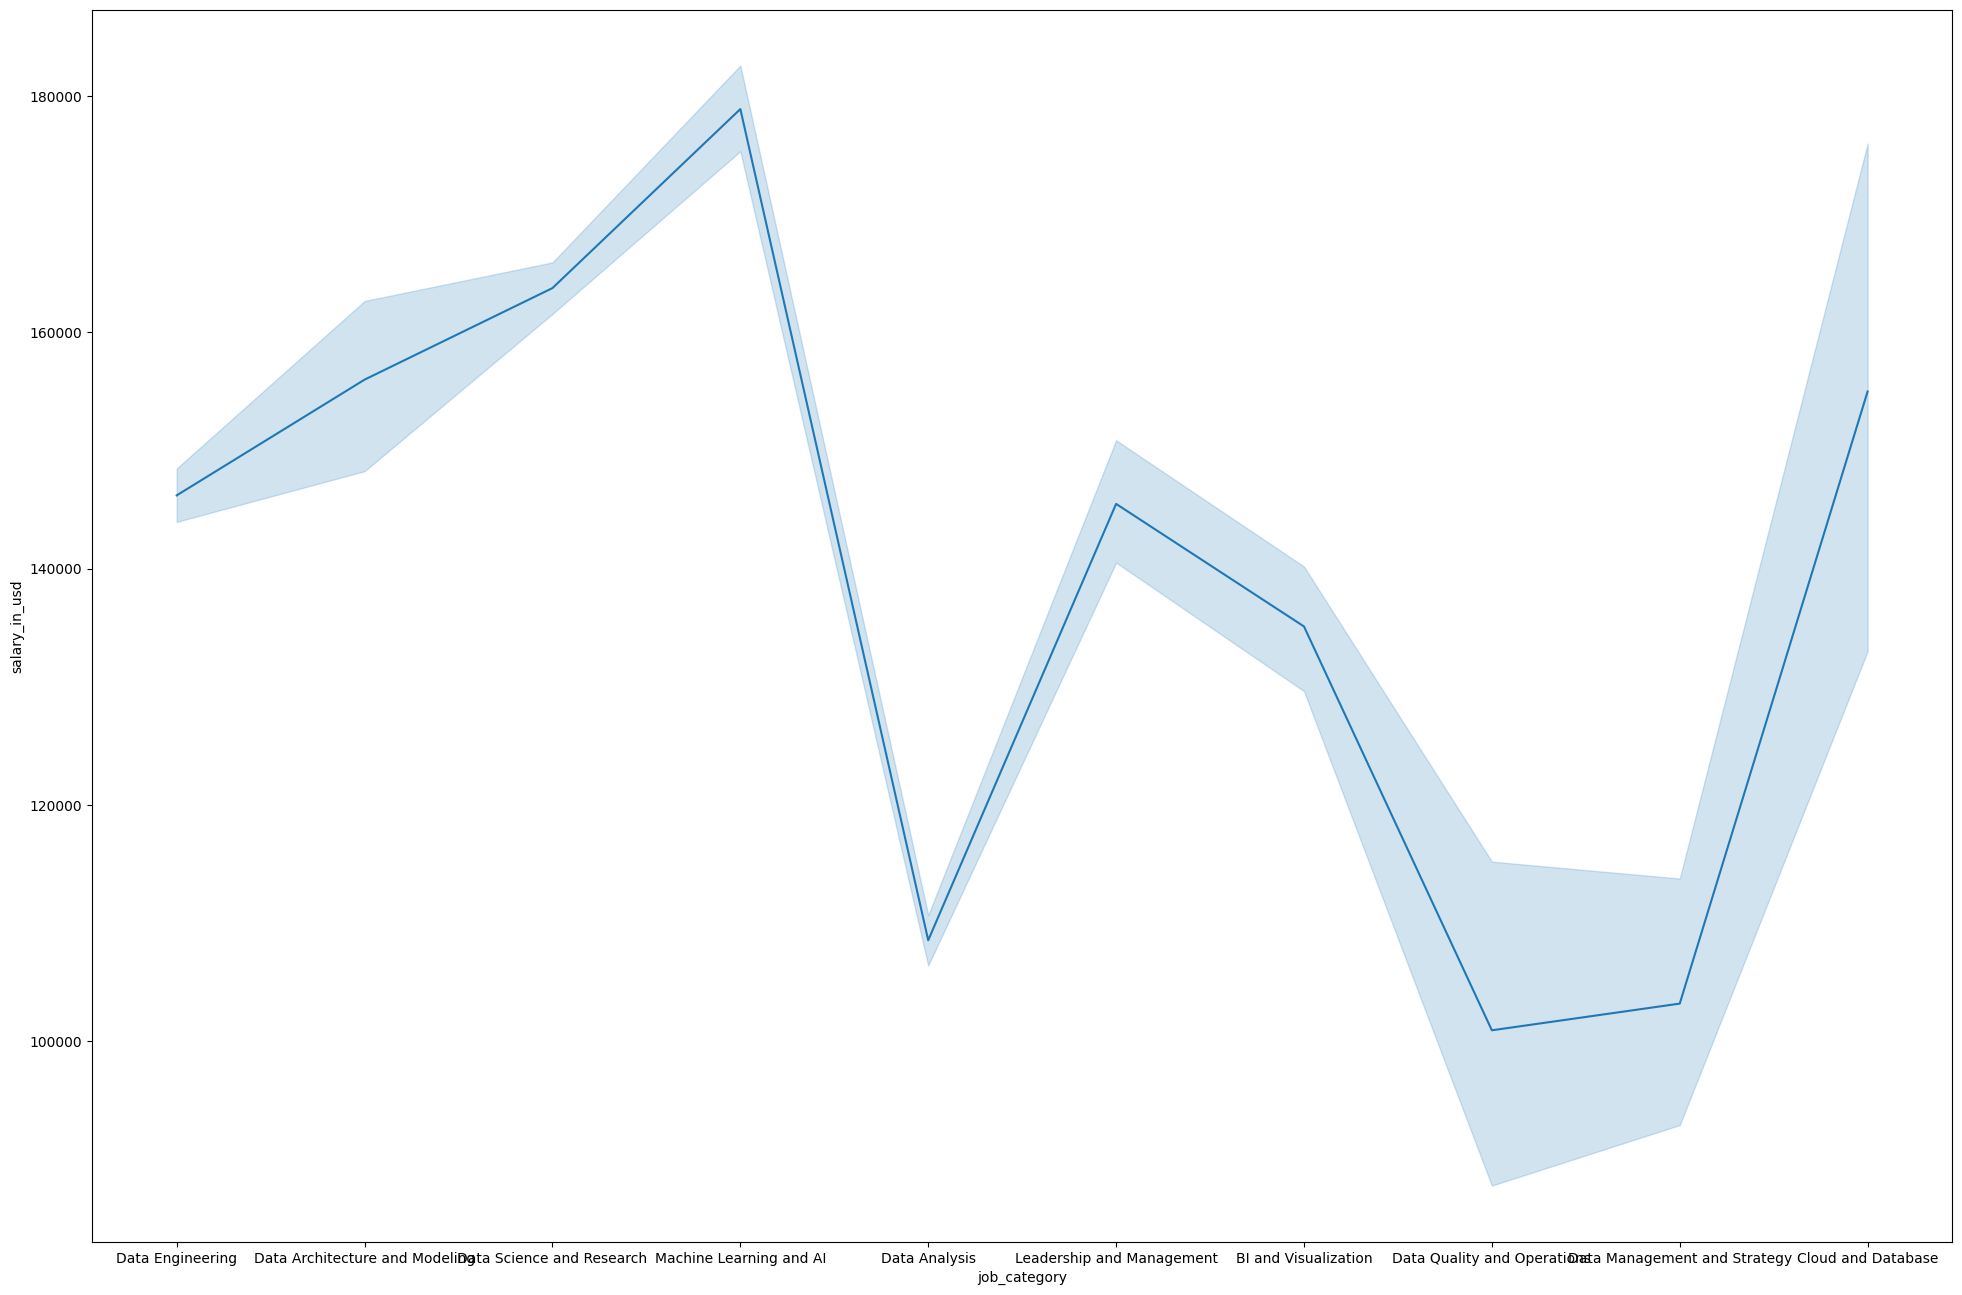

In [6]:
#Simple lineplot between job category and salary_in_usd
plt.figure(figsize=(24, 16))
sns.lineplot(x='job_category', y='salary_in_usd', data=jobs)
plt.show()

# 3- Data cleaning and preprocessing


### Data cleaning


In [7]:
# Check for duplicate rows
jobs.duplicated().sum()

# Remove duplicated
jobs.drop_duplicates(inplace=True)

# Remove salary column for a better representation of the data and other columns
jobs = jobs.drop(['salary'], axis=1)

# Find the number of missing values in each column
jobs.isna().sum()


work_year             0
job_title             0
job_category          0
salary_currency       0
salary_in_usd         0
employee_residence    0
experience_level      0
employment_type       0
work_setting          0
company_location      0
company_size          0
dtype: int64

###Split data

In [8]:
from sklearn.model_selection import train_test_split
#Splitting data before preprocessing to prevent data leakage
X = jobs.drop('salary_in_usd', axis=1)
y = jobs['salary_in_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

###Preprocessing

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

#create the cat and num columns
num_cols = X_train.select_dtypes(include='number').columns.to_list()
cat_cols = X_train.select_dtypes(exclude='number')
#need to create separate cat cols for high cardinality
large_cat_cols = cat_cols[['employee_residence','job_title', 'company_location']].columns.to_list()
cat_cols = cat_cols.drop(['employee_residence','job_title', 'company_location'], axis=1).columns.to_list()

#create pipelines for numeric and categorical columns
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(sparse_output=False))
large_cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), TargetEncoder())

#use ColumnTransformer to set the estimators and transformations
preprocessing = ColumnTransformer([('num', num_pipeline, num_cols),
                                   ('cat', cat_pipeline, cat_cols),
                                   ('largecat', large_cat_pipeline, large_cat_cols)],
                                    remainder='passthrough'
                                 )
display(preprocessing)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['work_year']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['job_category', 'salary_currency',
                                  'experience_level', 'employment_type',
                                  'work_setting', 'company_size']),
                                ('largecat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('targetencoder',
                                                  TargetEncoder())]),
                                 ['employee_residence', 'job_title',
                                  'company_location'])])

In [10]:
# Apply the preprocessing pipeline on the dataset
X_train = preprocessing.fit_transform(X_train, y_train)
feature_names=preprocessing.get_feature_names_out()
X_train = pd.DataFrame(data=X_train, columns=feature_names)

#Only apply transform on test set to prevent data leakage
X_test = preprocessing.transform(X_test)
X_test = pd.DataFrame(data=X_test, columns=feature_names)

display(X_train.head())
display(X_test.head())


,num__work_year,cat__job_category_BI and Visualization,cat__job_category_Cloud and Database,cat__job_category_Data Analysis,cat__job_category_Data Architecture and Modeling,cat__job_category_Data Engineering,cat__job_category_Data Management and Strategy,cat__job_category_Data Quality and Operations,cat__job_category_Data Science and Research,cat__job_category_Leadership and Management,...,cat__employment_type_Part-time,cat__work_setting_Hybrid,cat__work_setting_In-person,cat__work_setting_Remote,cat__company_size_L,cat__company_size_M,cat__company_size_S,largecat__0,largecat__1,largecat__2
0,0.521320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,158991.803424,114710.727965,158299.903942
1,0.521320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,158991.803424,155387.614380,158299.903942
2,0.521320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,158991.803424,179403.084964,158299.903942
3,-1.113834,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,158991.803424,109301.442404,158299.903942
4,0.521320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,158991.803424,150647.580918,158299.903942


,num__work_year,cat__job_category_BI and Visualization,cat__job_category_Cloud and Database,cat__job_category_Data Analysis,cat__job_category_Data Architecture and Modeling,cat__job_category_Data Engineering,cat__job_category_Data Management and Strategy,cat__job_category_Data Quality and Operations,cat__job_category_Data Science and Research,cat__job_category_Leadership and Management,...,cat__employment_type_Part-time,cat__work_setting_Hybrid,cat__work_setting_In-person,cat__work_setting_Remote,cat__company_size_L,cat__company_size_M,cat__company_size_S,largecat__0,largecat__1,largecat__2
0,0.521320,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,158991.803424,145292.179574,158299.903942
1,0.521320,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,158991.803424,109301.442404,158299.903942
2,-2.748989,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,158991.803424,124951.875336,158299.903942
3,-1.113834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,158991.803424,150647.580918,158299.903942
4,0.521320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,158991.803424,150647.580918,158299.903942


# 4- Train and evaluate three machine learning models

### Training
Linear Regression - Basis model for regression tasks

KNeighbours - Try and find patterns from neighbors

Random Forest - Will probably be the best performing algorithm

In [11]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

#Initialize regression functions and fit them to the training data
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)
KNN_model = KNeighborsRegressor(n_neighbors=16, p=1, weights='uniform')
KNN_model.fit(X_train, y_train)
rfr = RandomForestRegressor(n_estimators=850, min_samples_split=4, max_depth=6)
rfr.fit(X_train, y_train)

#Predicting the target from the test data
lr_y_predict = lr_model.predict(X_test)
knn_y_predict = KNN_model.predict(X_test)
rfr_y_pred = rfr.predict(X_test)


####Evaluating

In [12]:
from sklearn.metrics import mean_squared_error as mse
lr_mse=mse(y_test, lr_y_predict)
knn_mse = mse(y_test, knn_y_predict)
rfr_mse = mse(y_test, rfr_y_pred)
print(f'LR MSE: {lr_mse}')
print(f'KNN MSE: {knn_mse}')
print(f'RFR MSE: {rfr_mse}\n')

from sklearn.metrics import mean_absolute_percentage_error, r2_score
print("LR MAPE:{} R2:{}".format(mean_absolute_percentage_error(y_test, lr_y_predict), r2_score(y_test, lr_y_predict)))
print("KNN MAPE:{} R2:{}".format(mean_absolute_percentage_error(y_test, knn_y_predict), r2_score(y_test, knn_y_predict)))
print("RFR MAPE:{} R2:{}\n".format(mean_absolute_percentage_error(y_test, rfr_y_pred), r2_score(y_test, rfr_y_pred)))

print("Cross Validate 5 Folds:")
from sklearn.model_selection import cross_validate
res_lr = cross_validate(lr_model, X_train, y_train, cv=5, scoring=['neg_mean_absolute_percentage_error','r2'])
res_knn = cross_validate(KNN_model, X_train, y_train, cv=5, scoring=['neg_mean_absolute_percentage_error','r2'])
res_rfr = cross_validate(rfr, X_train, y_train, cv=5, scoring=['neg_mean_absolute_percentage_error','r2'])
print("LR MAPE:{} R2:{}".format(abs(res_lr['test_neg_mean_absolute_percentage_error'].mean()), res_lr['test_r2'].mean()))
print("KNN MAPE:{} R2:{}".format(abs(res_knn['test_neg_mean_absolute_percentage_error'].mean()), res_knn['test_r2'].mean()))
print("RFR MAPE:{} R2:{}".format(abs(res_rfr['test_neg_mean_absolute_percentage_error'].mean()), res_rfr['test_r2'].mean()))

LR MSE: 2648816806.478426
KNN MSE: 2847094613.5361905
RFR MSE: 2629680254.2436876

LR MAPE:0.3657488403798094 R2:0.37305785567917005
KNN MAPE:0.3818591997813283 R2:0.3261279535341841
RFR MAPE:0.3588123092558578 R2:0.37758724067235316

Cross Validate 5 Folds:
LR MAPE:0.35017592706459705 R2:0.36618250237932026
KNN MAPE:0.3579899425698019 R2:0.35046780278214074
RFR MAPE:0.3329354937883383 R2:0.3871562600436768


# 5- Discuss and analyze findings and compare the results of the three models

####Discussion and Analysis
MSE very high, doesn't necessarily mean performance of models are bad also have to factor the target column consisting of very large values in the hundred thousands.

Looking at the MAPE, ranging around 30-35% indicating predictions are not the best as 30% of the predictions deviate from the actual values.

R2 is used to see how well the model fit after seeing the MAPE. We notice that R2 is not very good at all. The models are having trouble finding correlation as there's 30%~ of the variability in the target column from the X columns.


Overall, our models don't seem to be predicting the best and could be due to a number of factors. We've tried a couple more models to no avail, as well as hypertuning below. It seems that the dataset features are not prominent enough to predict salaries consistently. Another factor could be the numerous categorical columns causing less precise predictions.


####Trying to improve the models
We ran GridSearchCV in attempt to hypertune KNN and Random Forest models.

We then went back to training and evaluating to check the results.

In [13]:
from sklearn.model_selection import GridSearchCV

#Created parameter grid for random forest(previously knn)
param_grid = {
    'n_estimators': [850, 900, 950],
    'max_depth': [6],
    'min_samples_split': [4],
}
#Grid search with r2 scoring
grid_search = GridSearchCV(rfr, param_grid, scoring='r2')
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
print("Best R2: ", grid_search.best_score_)


Best Parameters:  {'max_depth': 6, 'min_samples_split': 4, 'n_estimators': 850}
Best R2:  0.38734879867018235


# 6- 2+ graphs for the best-performing algorithm.
The best algorithm before and after hypertuning was the Random Forest algorithm

We decided on a simple scatterplot of actual vs predicted values with a line representing our model. As well as creating a Residual plot to visualize the variance of the points from the line.

#### Scatterplot of Actual vs Predicted values


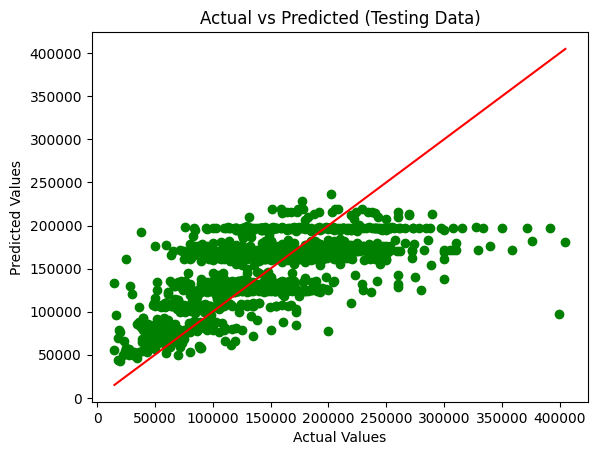

In [14]:
#Creating graphs again with plt
plt.scatter(y_test, rfr_y_pred, color='green', label='Testing data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted (Testing Data)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '-', color='red')  # Plotting the identity line
plt.show()

#### Residual Plot of Predicted vs Residuals

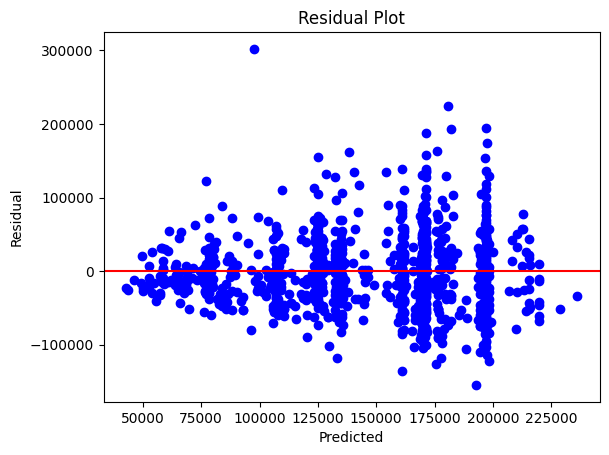

In [15]:
#Calculating residuals for every actual, predicted values
residuals = [actual - predicted for actual, predicted in zip(y_test, rfr_y_pred)]

#Creating graphs again with plt
plt.scatter(rfr_y_pred, residuals, color='blue')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()